# Assignment 8: Data Aggregation and Group Operations

## Overview
This assignment covers data aggregation and group operations using healthcare/insurance EHR data. You'll analyze patient encounters (insurance claims), healthcare providers, and medical facilities across different regions. The data includes provider statistics, facility information, and encounter charges with insurance coverage details.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
os.makedirs('output', exist_ok=True)

## Question 1: Basic GroupBy Operations

### Part 1.1: Load and Explore Data

**TODO: Load and merge the datasets**

In [2]:
# TODO: Load the three CSV files into dataframes
provider_df = pd.read_csv('data/provider_data.csv')
facility_df = pd.read_csv('data/facility_data.csv')
encounter_df = pd.read_csv('data/encounter_data.csv')

# TODO: Print the shapes of each dataframe
print("Provider data shape:", provider_df.shape)
print("Facility data shape:", facility_df.shape)
print("Encounter data shape:", encounter_df.shape)

# TODO: Merge the dataframes for analysis
# Hint: Start by merging encounter_df with provider_df on 'provider_id'
#       Then merge the result with facility_df on 'facility_id'
# Note: Both encounter_df and provider_df have 'facility_id', and both encounter_df and facility_df have 'region'
#       After merging, you may need to handle duplicate column names (pandas will add suffixes like _x and _y)
#       You can drop one of the duplicate columns and rename if needed
merged_df = pd.merge(encounter_df, provider_df, on='provider_id')
merged_df = merged_df.drop(columns=['facility_id_x'])
merged_df = merged_df.rename(columns={'facility_id_y': 'facility_id'})

merged_facility = pd.merge(merged_df, facility_df, on='facility_id')
merged_facility = merged_facility.drop(columns=['region_x'])
merged_facility = merged_facility.rename(columns={'region_y': 'region'})

# TODO: Print the merged dataframe shape, columns, and first few rows
# print("\nMerged data shape:", ...)
# print("\nColumns:", ...)
# print("\nFirst few rows:")
# print(...)
print("\nMerged data shape:", merged_facility.shape)
print("\nColumns:", merged_facility.columns.tolist())
print("\nFirst few rows:")
print(merged_facility.head())

Provider data shape: (500, 7)
Facility data shape: (10, 6)
Encounter data shape: (5000, 12)

Merged data shape: (5000, 21)

Columns: ['encounter_id', 'patient_id', 'provider_id', 'encounter_date', 'encounter_type', 'diagnosis_code', 'procedure_code', 'service_charge', 'insurance_paid', 'patient_paid', 'provider_name', 'provider_type', 'facility_id', 'specialty', 'years_experience', 'license_number', 'facility_name', 'facility_type', 'region', 'beds', 'established_date']

First few rows:
  encounter_id patient_id provider_id encounter_date        encounter_type  \
0     ENC00001   PAT01564      PR0259     2023-08-21          Office Visit   
1     ENC00002   PAT00296      PR0258     2023-09-11             Inpatient   
2     ENC00003   PAT01381      PR0213     2023-03-20                   Lab   
3     ENC00004   PAT01131      PR0146     2023-09-03  Outpatient Procedure   
4     ENC00005   PAT01388      PR0354     2023-06-14             Emergency   

  diagnosis_code  procedure_code  servi

### Part 1.2: Basic Aggregation

**TODO: Perform basic groupby operations**

In [3]:
# TODO: Group by facility (healthcare facility) and calculate basic stats
print("Group by Facility:")
print(merged_facility.groupby(by=["facility_name"]).describe())

# TODO: Calculate mean, sum, count for years_experience by facility
print("Group by Years of Experience:")
print(merged_facility.groupby(by = ["facility_name"]).agg({"years_experience": ['mean','sum', 'count']}))

# TODO: Calculate total encounter charges by facility
print("Group by Total Encounter Charges:")
merged_facility["total encounter charges"] = merged_facility["insurance_paid"] + merged_facility["patient_paid"] + merged_facility["service_charge"]
print(merged_facility.groupby(by = ["facility_name"]).agg({"total encounter charges": ['sum']}))
                                                            
# TODO: Calculate total insurance payments by facility
print("Group by Total Insurance Payments:")
print(merged_facility.groupby(by = ["facility_name"]).agg({"insurance_paid": ['sum']}))

# TODO: Find the facility with highest total encounter charges
print("Facility with Highest Total Encounter Charges:")
print(merged_facility.groupby(by = ["facility_name"]).agg({"total encounter charges": ["sum"]}).sort_values("facility_name", ascending = False).head(1))


# TODO: Create a summary dataframe with one row per facility showing:
#       facility_name, total_providers, avg_years_experience, total_service_charge, total_insurance_paid
# TODO: Save the summary dataframe as 'output/q1_groupby_analysis.csv'

summary = pd.DataFrame({
    'total_providers': merged_facility.groupby('facility_name')['provider_id'].agg('nunique'),
    'avg_years_experience': merged_facility.groupby('facility_name')['years_experience'].agg('mean'),
    'total_service_charge': merged_facility.groupby('facility_name')['service_charge'].agg('sum'),
    'total_insurance_paid': merged_facility.groupby('facility_name')['insurance_paid'].agg('sum')
}).reset_index()# TODO: Save the summary dataframe as 'output/q1_groupby_analysis.csv'
summary.to_csv("output/q1_groupby_analysis.csv", index = False)

Group by Facility:
                            procedure_code                              \
                                     count          mean           std   
facility_name                                                            
Cardiology Specialty Center          500.0  88151.542000  16536.462358   
City General Hospital                521.0  86924.856046  17471.951239   
Community Health Clinic              588.0  87925.454082  17142.161822   
Emergency Medical Center             463.0  89040.116631  15498.698368   
Northside Urgent Care                518.0  87930.851351  16614.213776   
Oncology Treatment Center            559.0  87842.302326  16279.356906   
Pediatric Care Center                427.0  87418.981265  16173.478781   
Primary Care Clinic                  462.0  87432.391775  16860.933822   
Regional Medical Center              425.0  88762.209412  16122.575897   
Surgical Specialty Center            537.0  88003.446927  15932.442176   

                  

### Part 1.3: Transform Operations

**TODO: Use transform operations to add group statistics**

In [4]:
# TODO: Add facility mean years_experience as new column
merged_facility["facility mean years_experience"] = merged_facility.groupby("facility_name")["years_experience"].transform("mean")
# TODO: Add facility standard deviation of years_experience
merged_facility["facility std years_experience"] = merged_facility.groupby("facility_name")["years_experience"].transform("std")
# TODO: Create normalized years_experience (z-score within facility)
merged_facility["facility normalized years_experience"] = merged_facility.groupby("facility_name")["years_experience"].transform(lambda x: (x - x.mean()) / x.std())

# TODO: Add facility total encounter charges as new column
merged_facility["facility total encounter charges"] = merged_facility.groupby("facility_name")["total encounter charges"].transform("sum")

# TODO: Display the enhanced dataframe

display(merged_facility)
# TODO: Save results as 'output/q1_aggregation_report.txt'

with open("output/q1_aggregation_report.txt", "w") as file:
    file.write("Assignment 8\n")
    file.write(merged_facility.to_csv(index = False))

,encounter_id,patient_id,provider_id,encounter_date,encounter_type,diagnosis_code,procedure_code,service_charge,insurance_paid,patient_paid,...,facility_name,facility_type,region,beds,established_date,total encounter charges,facility mean years_experience,facility std years_experience,facility normalized years_experience,facility total encounter charges
0,ENC00001,PAT01564,PR0259,2023-08-21,Office Visit,M79.3,99213,345.03,290.33,54.70,...,Cardiology Specialty Center,Specialty Center,West,21,2016-09-26,690.06,18.684000,11.242105,-0.683502,608578.76
1,ENC00002,PAT00296,PR0258,2023-09-11,Inpatient,N18.9,85025,550.48,482.51,67.97,...,Cardiology Specialty Center,Specialty Center,West,21,2016-09-26,1100.96,18.684000,11.242105,0.028109,608578.76
2,ENC00003,PAT01381,PR0213,2023-03-20,Lab,K21.9,80053,149.84,116.67,33.17,...,Emergency Medical Center,Specialty Center,South,344,2010-11-23,299.68,21.568035,10.914822,-1.701176,586145.60
3,ENC00004,PAT01131,PR0146,2023-09-03,Outpatient Procedure,H52.9,70450,1468.48,1198.71,269.77,...,Regional Medical Center,Urgent Care,South,459,1982-05-10,2936.96,18.614118,9.198635,-1.371303,523622.96
4,ENC00005,PAT01388,PR0354,2023-06-14,Emergency,G43.9,99214,672.23,507.22,165.01,...,Primary Care Clinic,Specialty Center,West,48,1995-09-13,1344.46,20.000000,11.978651,1.335710,547288.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,ENC04996,PAT01045,PR0065,2023-05-27,Emergency,K21.9,70450,5064.91,3932.06,1132.85,...,Regional Medical Center,Urgent Care,South,459,1982-05-10,10129.82,18.614118,9.198635,1.890050,523622.96
4996,ENC04997,PAT00658,PR0204,2023-09-26,Lab,M79.3,99214,191.82,150.07,41.75,...,Surgical Specialty Center,Urgent Care,West,474,1997-02-25,383.64,17.573557,11.779484,-0.218478,816374.98
4997,ENC04998,PAT01902,PR0174,2023-04-25,Emergency,J44.9,80053,347.27,267.46,79.81,...,Regional Medical Center,Urgent Care,South,459,1982-05-10,694.54,18.614118,9.198635,-0.392897,523622.96
4998,ENC04999,PAT00925,PR0083,2023-01-09,Lab,M79.3,99213,157.93,111.65,46.28,...,Emergency Medical Center,Specialty Center,South,344,2010-11-23,315.86,21.568035,10.914822,0.222813,586145.60


## Question 2: Advanced GroupBy Operations

### Part 2.1: Filter Operations

**TODO: Use filter operations to remove groups**

In [5]:
# TODO: Filter facilities with more than 20 providers (sufficient staffing)
merged_facility = merged_facility.groupby("facility_name").filter(
    lambda x: x["provider_id"].nunique() > 20)
# TODO: Filter facilities with average years_experience > 10 (experienced staff)
merged_facility = merged_facility.groupby("facility_name").filter(lambda x: x['years_experience'].mean() > 10)

# TODO: Filter facilities with total encounter charges > 250000 (high volume)

merged_facility = merged_facility.groupby("facility_name").filter(lambda x: x['total encounter charges'].sum() > 250000)


# TODO: Create a summary of filtered results

summary = pd.DataFrame({
    'total_providers': merged_facility.groupby('facility_name')['provider_id'].agg('nunique'),
    'avg_years_experience': merged_facility.groupby('facility_name')['years_experience'].agg('mean'),
    'total_service_charge': merged_facility.groupby('facility_name')['service_charge'].agg('sum'),
    'total_insurance_paid': merged_facility.groupby('facility_name')['insurance_paid'].agg('sum')
}).reset_index()
# TODO: Save results as 'output/q2_filter_analysis.csv'
summary.to_csv('output/q2_filter_analysis.csv')

### Part 2.2: Apply Operations

**TODO: Use apply operations with custom functions**

In [6]:
# TODO: Create custom function to calculate provider statistics
def provider_stats(group):
    # TODO: Return mean, std, min, max, range for years_experience
    return pd.Series({
        'mean': group["years_experience"].mean(),
        'std': group["years_experience"].std(),
        'min': group['years_experience'].min(),
        'max': group['years_experience'].max(),
        'range': group['years_experience'].max() - group['years_experience'].min()
    }
    )

In [7]:
# TODO: Apply custom function to each facility
# Note: Add include_groups=False to avoid pandas FutureWarning about groupby columns
facility_provider_stats = merged_facility.groupby('facility_name').apply(provider_stats, include_groups=False)

# TODO: Create function to find top providers in each facility
def top_providers(group, n=2):
    """Return top n providers in a group by encounter volume"""
    # TODO: Return top n rows by encounter count, selecting only provider_id, provider_name, 
    #       years_experience, specialty
    pass

    # Select top n providers by encounter count
    provider_summary = (
        group.groupby(['provider_id', 'provider_name', 'years_experience', 'specialty'])
             .agg(encounter_count=('encounter_id', 'count'))
             .reset_index()
    )

    # Sort providers by encounter_count (descending) and select top n
    top_n = provider_summary.sort_values('encounter_count', ascending=False).head(n)

    # Step 3: Return clean summary table
    return top_n

In [8]:
# TODO: Apply function to get top 2 providers per facility
# IMPORTANT: When using groupby().apply(), the result has a MultiIndex where:
# - Level 0: The grouping column (facility_name)
# - Level 1: The original row index from each group
# Use reset_index(level=0) to move only the grouping column back to a regular column
# DO NOT use reset_index(drop=True) - that would drop ALL index levels including facility_name!
top_providers_by_facility = merged_facility.groupby('facility_name').apply(
    lambda x: top_providers(x, n=2)
).reset_index(level=0)  # Moves facility_name from index to column

/var/folders/6w/gv8g6zzd417_9g9fl64d_nhc0000gn/T/ipykernel_72387/1511188468.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_providers_by_facility = merged_facility.groupby('facility_name').apply(


In [9]:
# TODO: Save results as 'output/q2_performance_report.txt'
with open("output/q2_performance_report.txt", "w") as f:
    f.write("=== Assignment 8 Performance Report ===\n")

    f.write("=== Facility Provider Stats ===\n")
    facility_provider_stats.to_csv(f)
    f.write("\n\n=== Top Providers by Facility===\n")
    top_providers_by_facility.to_csv(f)

### Part 2.3: Hierarchical Grouping

**TODO: Perform multi-level grouping**

In [10]:
# TODO: Group by facility type and region
print("Original dataset:")
# TODO: Calculate statistics for each facility_type-region combination
new_df = merged_facility.groupby(["facility_type", "region"]).agg({'service_charge': 'sum', 'insurance_paid': 'sum', 'patient_paid': 'sum'})

# TODO: Use unstack to convert to wide format
print("Wide format:")
wide_format = new_df.unstack()
print(wide_format)

# TODO: Use stack to convert back to long format
print("Long format:")
long_format = wide_format.stack()
print(long_format)

# TODO: Analyze the hierarchical structure
# In the wide format, facility types are represented as the primary index level (represented as rows).
# The columns have three levels including, level 1: service_charge, insurance_paid, patient_paid
# Column level 2 is by region: North, South, West
# Within each cell is the total sum of the various costs (i.e., service_charge, insurance_paid, patient_paid) by facility_type X service_charge X region. 

# In the long format, each row represents a unique combination of facility_type and region.
# The columns represent the sum of various charges (i.e., service_charge, insurance_paid, patient_paid).
# Each cell contains the corresponding aggregated value for that facility_type-region combination.

# TODO: Save results as 'output/q2_hierarchical_analysis.csv'

long_format.to_csv("output/q2_hierarchical_analysis.csv")

Original dataset:
Wide format:
                 service_charge                       insurance_paid  \
region                    North      South       West          North   
facility_type                                                          
Hospital                    NaN  368222.45        NaN            NaN   
Specialty Center            NaN  559867.92  577933.87            NaN   
Urgent Care           358721.75  618049.37  718630.33      286450.39   

                                       patient_paid                        
region                South       West        North      South       West  
facility_type                                                              
Hospital          297831.91        NaN          NaN   70390.54        NaN  
Specialty Center  445399.33  461960.30          NaN  114468.59  115973.57  
Urgent Care       495204.64  576103.95     72271.36  122844.73  142526.38  
Long format:
                         service_charge  insurance_paid  patient_pa

/var/folders/6w/gv8g6zzd417_9g9fl64d_nhc0000gn/T/ipykernel_72387/1120795607.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long_format = wide_format.stack()


## Question 3: Pivot Tables and Cross-Tabulations

### Part 3.1: Basic Pivot Tables

**TODO: Create pivot tables for multi-dimensional analysis**

In [11]:
# TODO: Create pivot table: encounter charges by procedure code and region
pivot_simple = pd.pivot_table(merged_facility, values="total encounter charges", index='procedure_code', columns='region')
print(pivot_simple)
# TODO: Create pivot table with multiple aggregations (sum, mean, count)
multiple_agg = pd.pivot_table(merged_facility, values="total encounter charges", index='procedure_code', columns='region', aggfunc=["sum", "mean", "count"])
print(multiple_agg)
# TODO: Add totals (margins) to pivot table
pivot_totals = pd.pivot_table(merged_facility, values="total encounter charges", index='procedure_code', columns='region', aggfunc=["sum", "mean", "count"],  margins = True)
print(pivot_totals)
# TODO: Handle missing values with fill_value
missing_values_filled = pd.pivot_table(merged_facility, values="total encounter charges", index='procedure_code', columns='region', aggfunc=["sum", "mean", "count"], margins = True, fill_value = 0, margins_name = "total amount")
missing_values_filled.columns = ['_'.join(map(str, col)).strip() for col in missing_values_filled.columns.values]

# Reset index if you want procedure_code as a column instead of an index
missing_values_filled = missing_values_filled.reset_index()
print(missing_values_filled)

# Tip: When saving a pivot table to CSV, the index (row labels) is preserved by default.
#      This is usually desired - when reading back, use index_col=0 to restore the index.
# TODO: Save results as 'output/q3_pivot_analysis.csv'
with open("output/q3_pivot_analysis.csv", "w") as f:
    missing_values_filled.to_csv(f)

region                North        South         West
procedure_code                                       
36415           1005.235263   814.660308   835.549189
70450           5123.634483  5457.638298  5411.497966
70551           5084.328182  5983.267042  5545.225231
72040            711.820000   890.737212   922.618143
80053            502.185000   582.785564   575.636742
85025            615.148780   581.326883   594.713957
93000            722.738182   785.916400   857.075464
99213            974.386424   987.475580   945.691450
99214            928.556121   969.740579   962.843383
99283            862.801818   870.589552  1052.402041
                      sum                               mean               \
region              North      South       West        North        South   
procedure_code                                                              
36415            38198.94  105905.84   92745.96  1005.235263   814.660308   
70450           148585.40  769527.00  638556

### Part 3.2: Cross-Tabulations

**TODO: Create cross-tabulations for categorical analysis**

In [12]:
# TODO: Create crosstab of facility type vs region with counts
cross_tab_1 = pd.crosstab(merged_facility["facility_type"], merged_facility["region"])
print("cross_tab_1:")
print(cross_tab_1)
# TODO: Create crosstab with margins (row and column totals)
cross_tab_2 = pd.crosstab(merged_facility["facility_type"], merged_facility["region"], margins = True)
print("cross_tab_2:")
print(cross_tab_2)
# TODO: Create multi-dimensional crosstab showing facility type × encounter type × region combinations
#       (Hint: use pd.crosstab with multiple index/column parameters, or create manually from the data)
cross_tab_3 = pd.crosstab([merged_facility["facility_type"], merged_facility["encounter_type"]], merged_facility["region"], margins = True)
print("cross_tab_3:")
print(cross_tab_3)
# TODO: Analyze the cross-tabulation results
# In cross_tab_1, we see that the South region has the highest counts across most facility types, indicating a higher concentration of facilities there, as well as a greater diversity of facility types.
# In cross_tab_1, the North region has the lowest counts and only Urgent Care Centers are present there. Moreover, the West region has moderate counts with Speciality Centers and Urgent Care Centers.
# Cross_tab_3 shows the breakdown of encounter types within each facility type across regions. 
# For the North region, the types of Urgent Care seem evenly distributed with the highest count in Emergency encounters.
# For the South and West regions, each facility type by encounter type seemed evenly distributed as well. For the West region, there were slightly higher counts for Emergency encounters and Lab visits.

# TODO: Save results as 'output/q3_crosstab_analysis.csv'
with open("output/q3_crosstab_analysis.csv", "w") as f:
    cross_tab_3.to_csv(f)
# TODO: Save results as 'output/q3_crosstab_analysis.csv'

cross_tab_1:
region            North  South  West
facility_type                       
Hospital              0    559     0
Specialty Center      0    890   962
Urgent Care         588    946  1055
cross_tab_2:
region            North  South  West   All
facility_type                             
Hospital              0    559     0   559
Specialty Center      0    890   962  1852
Urgent Care         588    946  1055  2589
All                 588   2395  2017  5000
cross_tab_3:
region                                 North  South  West   All
facility_type    encounter_type                                
Hospital         Emergency                 0    106     0   106
                 Inpatient                 0    127     0   127
                 Lab                       0    107     0   107
                 Office Visit              0    102     0   102
                 Outpatient Procedure      0    117     0   117
Specialty Center Emergency                 0    186   202   388
      

### Part 3.3: Pivot Table Visualization

**TODO: Create visualizations from pivot tables**

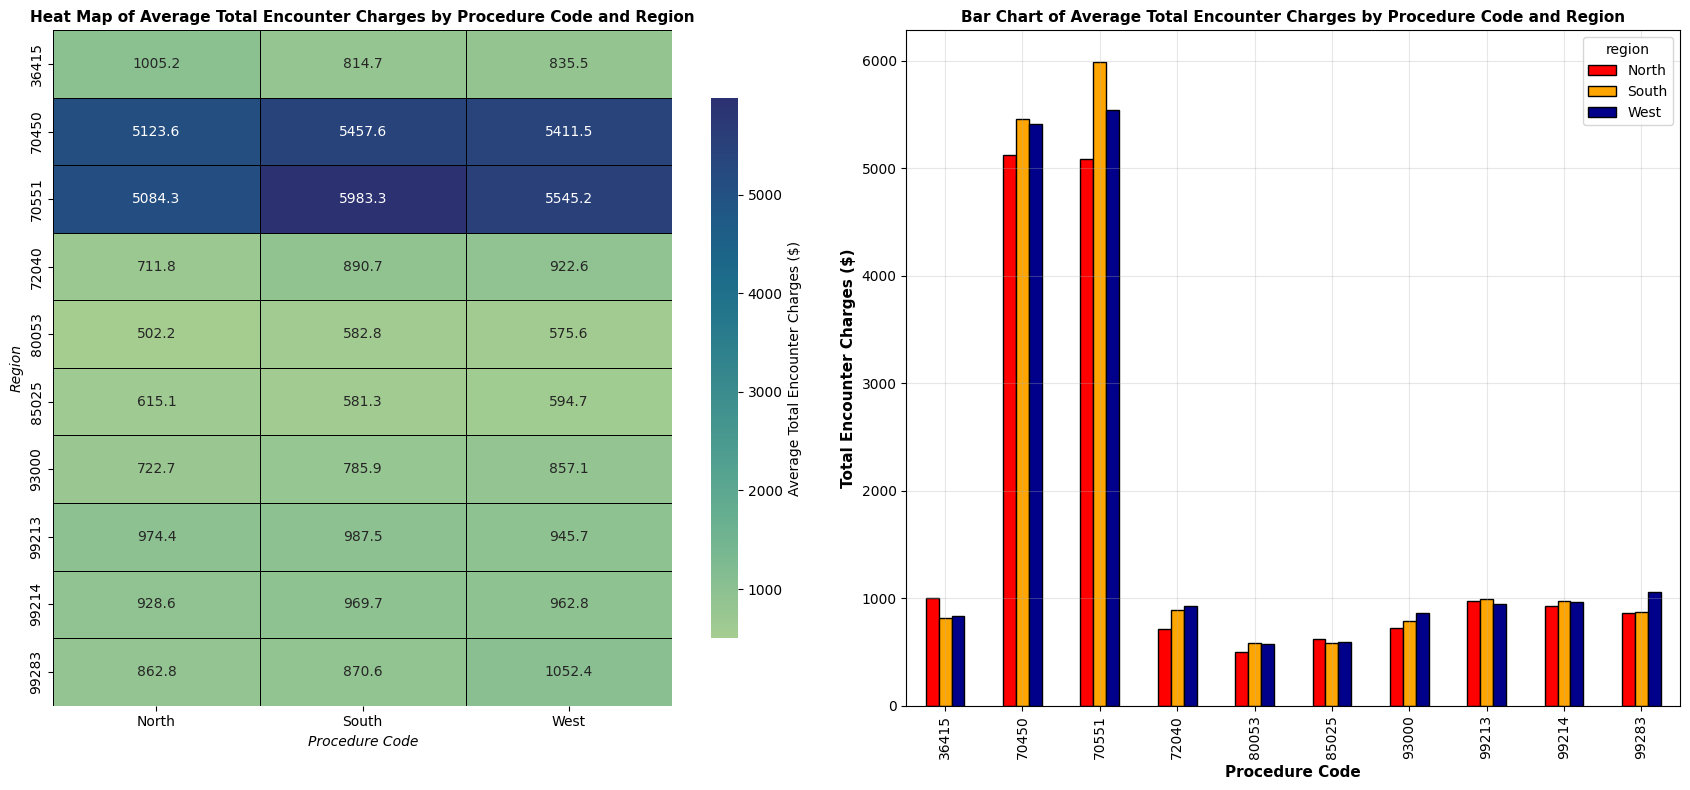

In [13]:
# TODO: Create heatmap from pivot table
fig, axes = plt.subplots(1, 2, figsize=(17, 8))
sns.heatmap(pivot_simple, annot=True, fmt=".1f", linewidth=.5, cmap="crest", linecolor = "black", ax = axes[0],
            cbar_kws={"shrink": .8, "label":"Average Total Encounter Charges ($)"})
axes[0].set_title('Heat Map of Average Total Encounter Charges by Procedure Code and Region', fontsize=11, fontweight='bold', )
axes[0].set_xlabel('Procedure Code', fontstyle = "italic")
axes[0].set_ylabel('Region', fontstyle = "italic")
# axes[0].grid(True, linestyle='--', alpha=0.6)

# TODO: Create bar chart from pivot table
pivot_simple.plot(ax = axes[1], kind = "bar", color=['red', 'orange', 'darkblue'], edgecolor = 'black')
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Bar Chart of Average Total Encounter Charges by Procedure Code and Region', fontsize = 11, fontweight = "bold")
axes[1].set_xlabel('Procedure Code', fontsize = 11, fontweight = "bold")
axes[1].set_ylabel('Total Encounter Charges ($)', fontsize = 11, fontweight = "bold")
plt.tight_layout()
# TODO: Customize colors and styling
# TODO: Add appropriate titles and labels

plt.savefig('output/q3_pivot_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
# TODO: Save the plot as 'output/q3_pivot_visualization.png'

## Submission Checklist

Before submitting, verify you've created:

- [ ] `output/q1_groupby_analysis.csv` - Basic groupby analysis
- [ ] `output/q1_aggregation_report.txt` - Aggregation report
- [ ] `output/q2_filter_analysis.csv` - Filter operations analysis
- [ ] `output/q2_hierarchical_analysis.csv` - Hierarchical analysis
- [ ] `output/q2_performance_report.txt` - Performance report
- [ ] `output/q3_pivot_analysis.csv` - Pivot table analysis
- [ ] `output/q3_crosstab_analysis.csv` - Cross-tabulation analysis
- [ ] `output/q3_pivot_visualization.png` - Pivot visualization

## Key Learning Objectives

- Master the split-apply-combine paradigm
- Apply aggregation functions and transformations
- Create pivot tables for multi-dimensional analysis
- Apply advanced groupby techniques